# Latent Variable Tutorial

Are you building a Bayesian Network (BN) and facing one of the two situations below?

1. You wish to include a very important variable in your model but the amount of high quality data you have about it is extremely low?
2. Or you wish to include a variable for which you have no data at all, but have significant quantitative knowledge about the dependencies of this variable and the rest of the model?

In this tutorial, we show step by step how to add such a variable to your model. 
Here we shall focus on the interpretability aspect, i.e., we wish to learn condition probability distribution (CPD) 
parameters that actually represent the latent variable (LV) that we wish to include. 
This is an overall problem in Latent Variable Model (LVM) and we establish mechanisms to tackle this problem.

**Note**: To maintain code simplicity, we encapsulate some of the utility functions in [tutorial_utils.py](./tutorial_utils.py) and make use of these functions in this tutorial.

## Adding a latent variable

Several reasons may motivate us to try to include an LV, for example:

- **Obtaining true causality** - 
    We know from expert knowledge that adding an LV may create a confounding effect on the existing variables.
    For example, consider a simple structure below:

    ![simple](supporting_files/simple.jpg)

    Adding a confounding LV $Z$ might better capture the causal relationship between variables $a$ and $b$:

    ![confounding](supporting_files/simple_confounding.jpg)
    
- **Improving performance** -
    Including an LV changes the BN structure and can improve performance.
    Depending on how the LV is included, this may reduce the number of parameters and avoid overfitting,
    or otherwise increase the number of parameters and make the model more complex.
    Consider a structure below, where all parent nodes are directly connected to all child nodes:

    ![parent-child](supporting_files/parent_child.jpg)

    Introducing an LV $Z$ in between the parents and children helps reduce the number of parameters and mitigate overfitting:

    ![parent-latent-child](supporting_files/parent_latent_child.jpg)

### Overview of steps

In this tutorial, we will manually include an LV $Z$ in the BN structure and then use the Expectation-Maximization (EM) algorithm to learn the parameters related to this variable. This involves several steps:

| Step | Description                                                 | Remark                                                                                                         |
| ---- | ----------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| 1    | Build a network with no LV and train it on complete data    | We fit the [CPD](./05_latent_variable_tutorial.html#Definitions) parameters before introducing the latent variable |
| 2    | Identify an LV and how it interacts with the model          | We should specify which dependencies should be introduced and which ones should be removed                     |
| 3    | Add the LV to the model                                     | Use the method `BayesianNetwork.add_node` to add edges to/from this LV and to remove variables that are now explained by the LV. This ensures the graph remains causal and the LV has the desired meaning. Guidelines on which sets of edges to add/remove are provided in the [Appendix](./05_latent_variable_tutorial.html#Appendix) |
| 4    | Establish constraints to the [CPDs](./05_latent_variable_tutorial.html#Definitions) related to the LV  | Use the methods `EMSingleLatentVariable.get_default_priors` and `EMSingleLatentVariable.get_default_box` to provide constraints based on expert knowledge and little amount of data available, respectively. This would in turn help the learned parameters converge to those that the user desires |
| 5    | Fit the [CPDs](./05_latent_variable_tutorial.html#Definitions) related to the LV using the EM algorithm | Use the method `BayesianNetwork.fit_latent_cpds` to learn/update the parameters of the LV and its children |

### Expectation-Maximization

The Expectation-Maximization (EM) algorithm is an iterative method to find the Maximum Likelihood Estimator (MLE) or Maximum a Posteriori (MAP) in the presence of latent variables. It is a general algorithm, not restricted only to Bayesian Networks. It works by alternating between two steps:

- **Expectation (E-step)** -
    Given the current state of model parameters, we estimate the expected log likelihood.
    This expected value takes into account all the values the LV can assume and their probabilities.
    More formally, if $Z$ is the latent variable, $\theta$ is the current parameters, and $X$ is the realisations of the observed of variables, we compute:

    $Q(X|\theta) = \int \log P(X,Z|\theta) dZ$

    Note that $Q$ is a lower bound for the model log likelihood. Based on the Jensen inequality $f(E[X]) \geq E[f(X)]$ for concave function $f$ (including $\log$ in this case), we can get the following:

    $L(X|\theta) = \log P(X|\theta) = \log \int P(X,Z|\theta)dZ \geq Q(X|\theta)$

- **Maximisation (M-step)** -
    Update the parameters to maximise the expectation computed in the previous step:

    $\arg \max_{\theta} Q(X|\theta)$

For interested readers, please refer to the original EM work at [[2]](./05_latent_variable_tutorial.html#References)

#### Guarantees and limitations

EM comes with guarantees and limitations. The main guarantees are:

- Successive steps always improve the likelihood
- It converges to a local maxima in the likelihood function

We also address several limitations below:

- **Interpretability**
    - It is difficult to ensure that the meaning of the LV is as desired. For example, EM might learn the parameters for a different variable than the one we desire.
    - To address this, we can either provide some data about the LV (in many cases a few samples may suffice) or impose constraints on the parameters.
      The constraints currently allowed in our implementation will be covered [below](./05_latent_variable_tutorial.html#Constraints).

- **Computational complexity**
    - Because we need to consider all values of the LV in the E-step, each iteration is slower than MLE due to extra (linear) complexity associated with the cardinality of the LV.
    - Also, as many iterations may be needed for convergence, the algorithm can be slow for large datasets.
      The current implementation may scale up to few tens of thousands of data points, but there may be room for further optimisation.

#### Our implementation

Our EM implementation in CausalNex is captured in the `EMSingleLatentVariable` class, which is invoked from the `fit_latent_cpds` method under the `BayesianNetwork` class.

`EMSingleLatentVariable` runs the EM algorithm in order to learn the [CPDs](./05_latent_variable_tutorial.html#Definitions) of a specified LV along with its children/successors.
This is based on the property outlined [here](./05_latent_variable_tutorial.html#Appendix).

#### Constraints

It is important to note that we can and should provide constraints to the learned parameters in three different ways:

- Provide some quantity of data (in many cases 50-100 samples would be enough)
- Use argument `box_constraints` to constrain each CPD parameter to be inside a given interval (say, $P(A=1|B=0,C=1) \in [0.1, 0.5]$)
- Use argument `priors` to provide specific Dirichlet priors

These constraints are very important if we want to interpret the meaning of our latent variable. Without them, EM could converge to a local maximum representing a different unobserved variable.

### Case study: Student performance data

In this case study, we demonstrate an application of EM to the [student performance dataset](https://archive.ics.uci.edu/ml/datasets/Student+Performance) from [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml).
In particular, you will need download the [student.zip](https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip) file and extract `student-por.csv` from the zip file into the same directory as this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import warnings
import numpy as np
import pandas as pd
import tutorial_utils as utils

logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100

/Users/gabriel_azevedo_ferreira/opt/miniconda3/envs/private-causalnex-39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We assume that we have NO DATA about the students' grade on the first exam of the semester, i.e., `G1`.
We try to recover this variable with the assumption that students tend to perform similarly in two successive exams.

In the original dataset, this variable is provided. We keep this in `g1_column` to check the accuracy of our solution later.

In [3]:
df = pd.read_csv('student-por.csv', delimiter=";")
g1_column = df["G1"]
df["G1"] = np.nan
print("dataset rows and columns: ", df.shape)
df.head()

dataset rows and columns:  (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,NaN,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,NaN,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,NaN,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,NaN,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,NaN,13,13


The structure we started with does not contain the variable `G1`.
In the section below, we highlight the edges that we will remove when adding `G1` to the model.

In [4]:
from causalnex.plots import plot_structure
from tutorial_utils import plot_options_2 

sm, g1_edges_to_add, g1_edges_to_remove = utils.load_structure_model_and_remove_variable(
    "./supporting_files/student.dot", 
    "G1",
)
viz = utils.plot_pretty_structure(sm, edges_to_highlight=g1_edges_to_remove)
viz.set_options(plot_options_2["pyvis_options"])
viz.show('supporting_files/05_plot.html')

#### Building a network with no LV and train it on complete data

Below we learn the network CPDs for the structure model without `G1`.

In [5]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

# Dropping `VehicleYear` because the `fit_node_states` does not accept missing values
bn.fit_node_states_and_cpds(df.drop(['G1'], axis=1))

#### Identifying an LV and how it interacts with the model

We need to carefully identify what dependencies this variable would have in the system.
Here we identify `G1` as LV and insert it in between `G2` and its parents.

To this end, we specify new edges from/to `G1`, as well as edges to be removed between `G2` and its parents.

In [6]:
print("We are going to add:")
print(g1_edges_to_add)
print("\nWe are going to remove:")
print(g1_edges_to_remove)

We are going to add:
[('school', 'G1'), ('G1', 'G2'), ('address', 'G1'), ('studytime', 'G1'), ('failures', 'G1'), ('higher', 'G1')]

We are going to remove:
[('school', 'G2'), ('address', 'G2'), ('studytime', 'G2'), ('failures', 'G2'), ('higher', 'G2')]


#### Adding the LV to the network

We can now add the LV `G1` into our network as follows.

__Important Note__: Please make sure that all the new edges being added are only connecting nodes that are already existing in the current subgraph. To connect the LV to additional nodes that are not in the current subgraph (this would be the largest subgraph by default)
1. Add the additional nodes and relevant edges into the subgraph.
2. Then use `fit_node_states_and_cpds()` to fit their states and cpds.
3. Continue with the below tutorial steps to add the LV node, boundaries, priors before using `fit_latent_cpds()` 

In [7]:
bn.add_node(
    node="G1",
    edges_to_add=g1_edges_to_add,
    edges_to_remove=g1_edges_to_remove,
)

In [8]:
viz = utils.plot_pretty_structure(bn.structure, edges_to_highlight=g1_edges_to_add)
viz.set_options(plot_options_2["pyvis_options"])
viz.show("supporting_files/05_new_edges.html")

#### Establishing constraints to the parameters related to the LV

As explained [here](./05_latent_variable_tutorial.html#Constraints#Constraints), our implementation supports a few types of constraints, 
and it is very important to provide these constraints. 
Below we exemplify how to provide `box_constraints` and `priors`.

We provide constraints to the distribution $P(G2|G1)$ based on the assumption that grades in two successive exams are similar. 
In general, we need to provide constraints to the LV's [CPD](./05_latent_variable_tutorial.html#Definitions)
(i.e., $P(G1|Parents(G1)$) and to each of its children CPDs (i.e., $P(G2|Parents(G2)$)

##### Box constraints

The default box constraints are the interval $(0, 1)$ for each parameter. 
We can shorten this interval by overriding the default box constraints.

We need to provide min/max boundaries for the LV's CPD and the LV's children CPDs. In this case:
dict_keys(['G2', 'G1'])

The default boundaries for every parameter is (0,1), and we should override as many of these values as we can:

Overriding maximum:


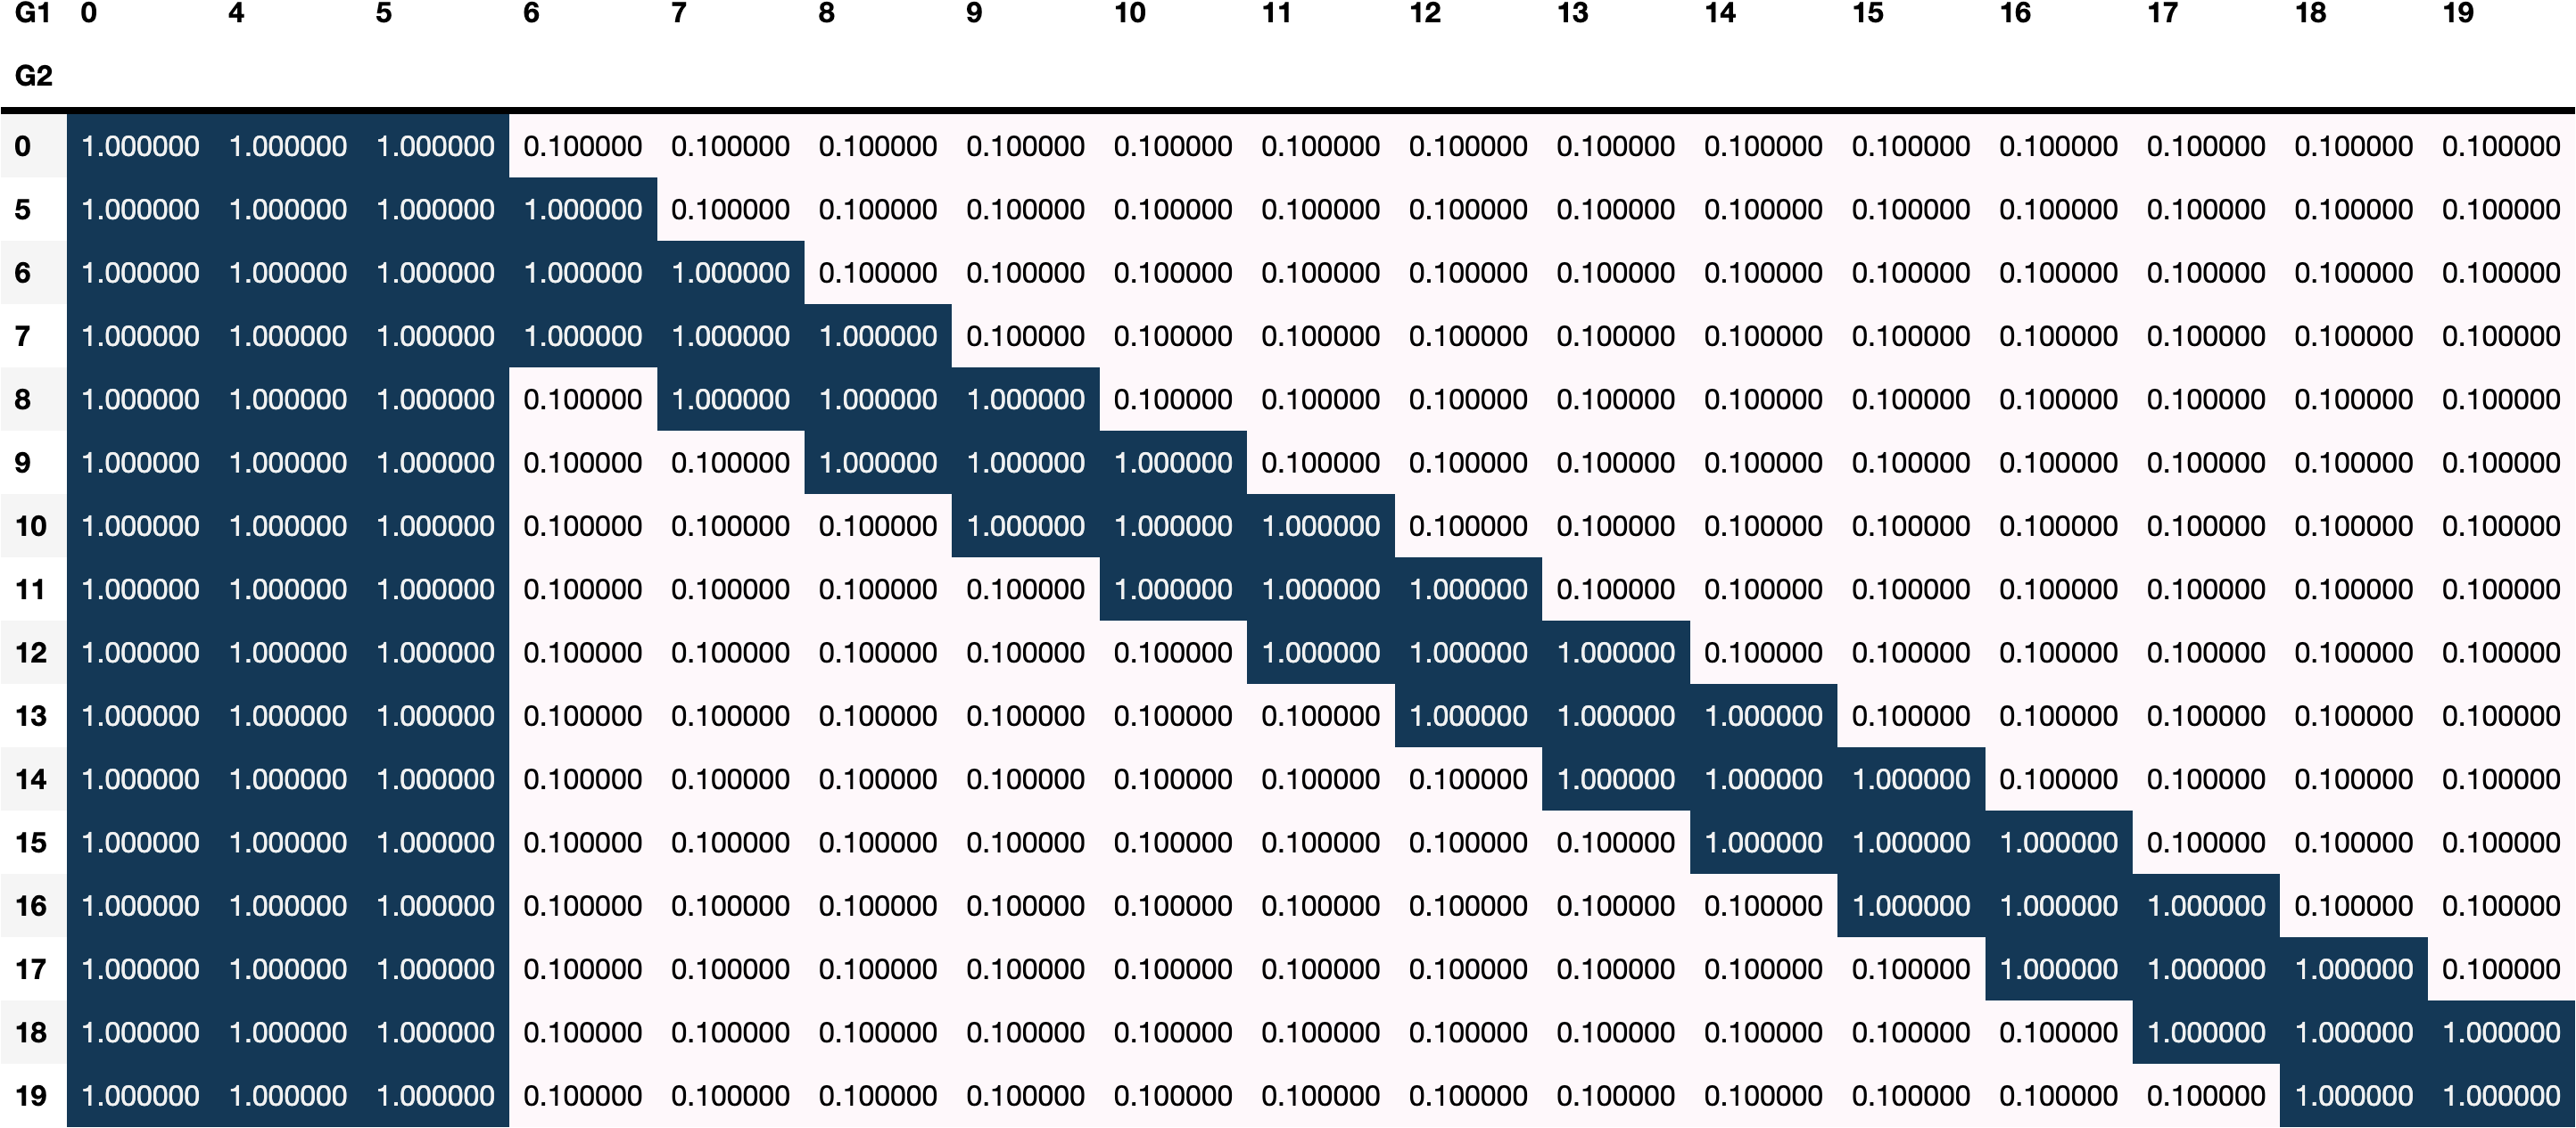

In [9]:
from causalnex.estimator.em import EMSingleLatentVariable

# This returns the default box constraints as a dictionary of pd.Dataframes
# We alter this dictionary to provide custom boundaries
boundaries = EMSingleLatentVariable.get_default_box(
    sm=bn.structure,
    node_states={
        **bn.node_states,
        'G1': {0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
    },
    lv_name='G1'
)
print("We need to provide min/max boundaries for the LV's CPD and the LV's children CPDs. In this case:")
print(boundaries.keys())

print("\nThe default boundaries for every parameter is "
      "(0,1), and we should override as many of these values as we can:")
print("\nOverriding maximum:")

for i in range(6, 20):
    boundaries['G2'][1].loc[:i -2 ,i] = .1 # proba of G2 << G1 is at most 10% 
    boundaries['G2'][1].loc[i +2: ,i] = .1 # proba of G2 >> G1 is at most 10% 

utils.display_colored_df(boundaries['G2'][1])

##### Priors

We can also provide priors to the CPDs. In particular, we can provide priors to the LV's CPD and the LV's children CPDs.

It is sufficient to provide any positive number to each CPD entry. We can interpret the Dirichlet priors in the following manner:

- Each value in a column, normalised by the sum of the values in that column, represents the parameter we believe to be the right one.
- The sum of values in the same column represents the strength of that belief: the higher that sum, the more your initial belief will be incorporated in the final parameters. 
- If we do not have a priori estimation, we can use the value zero for the whole column.

Below we provide an example of specifying priors for $P(G2|G1)$. 

> Note that we did not provide any prior for $G1 \in \{0, 4, 5\}$, which means that the "strength of our belief is zero" for these values of $G1$.

> Also note that we do not need to be right on all of these beliefs. The algorithm will incorporate them along with data to learn the best parameters.

We provide default prior for the LV CPD and its children's
dict_keys(['G2', 'G1'])
The default Priors are 0, and we can override these values


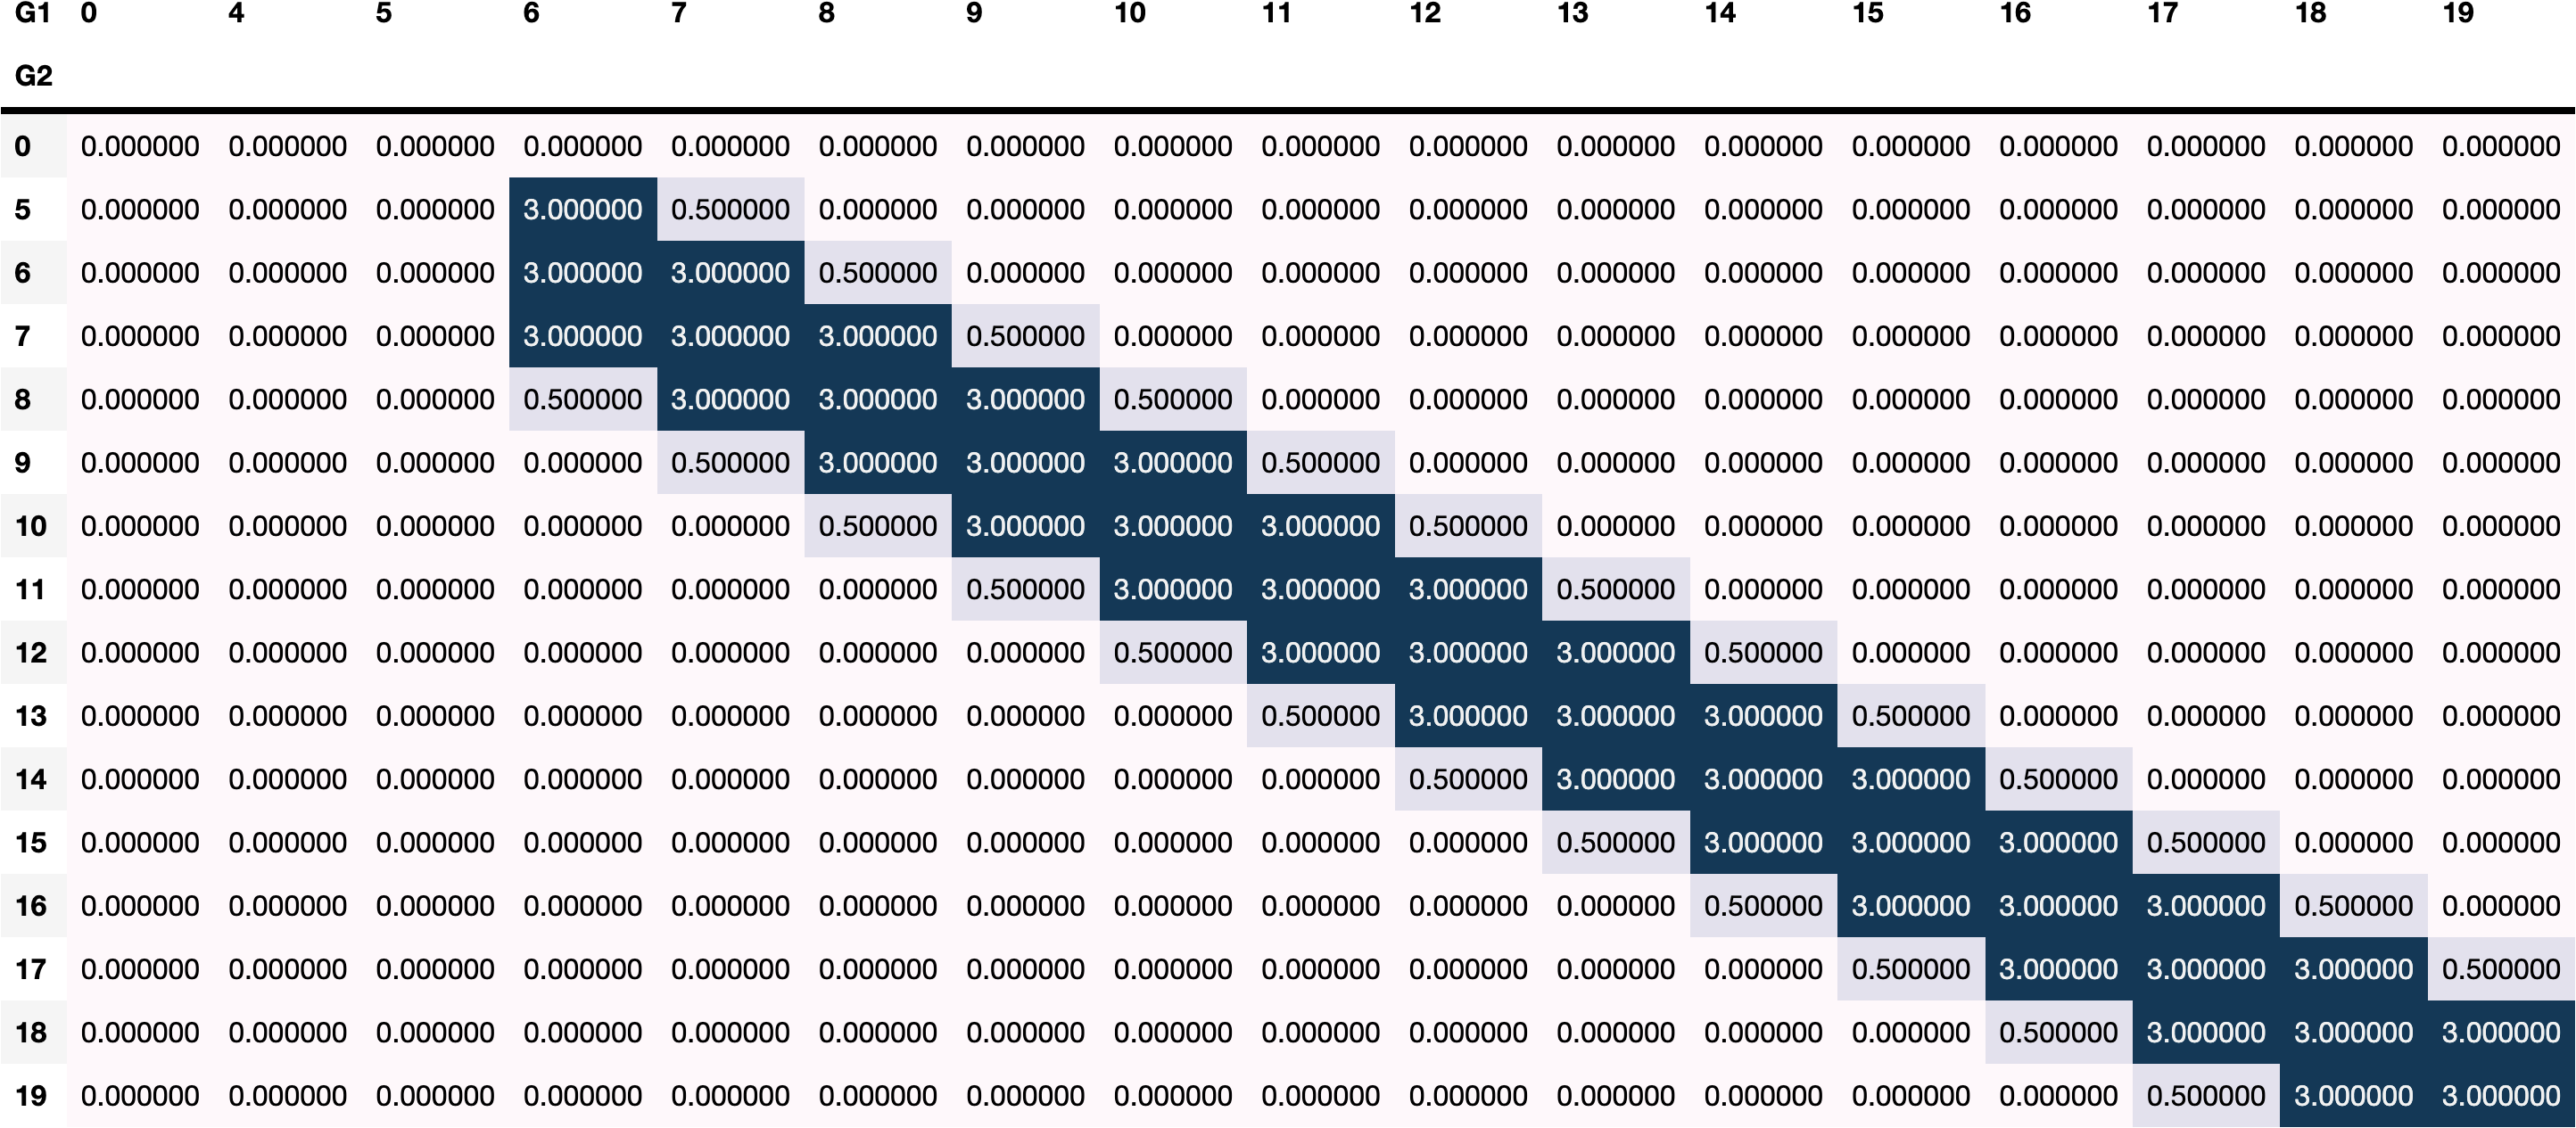

In [10]:
priors = EMSingleLatentVariable.get_default_priors(
    sm=bn.structure,
    node_states={
        **bn.node_states,
        'G1': {0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
    },
    lv_name='G1',
)
print("We provide default prior for the LV CPD and its children's")
print(priors.keys())

print("The default Priors are 0, and we can override these values")

strength = 10

for i in range(6, 20):
    priors['G2'].loc[i-2:i-1 ,i] = .05 * strength  # probability X strength
    priors['G2'].loc[i+1:i+2 ,i] = .05 * strength  # probability X strength
    priors['G2'].loc[i-1:i +1 ,i] = .3 * strength  # probability X strength

utils.display_colored_df(priors['G2'])

#### Fitting the parameters of the LV and its children 

We do not need to refit (re-learn) all the CPD parameters of all nodes in the BN.
Based on [this](#property-em) property, only a small number of parameters need to be learned: the CPD of LV and that of its children.

In [11]:
# This takes several minutes...
bn.fit_latent_cpds(
    lv_name="G1",
    lv_states=[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    data=df,
    box_constraints=boundaries,
    priors=priors,
    n_runs=30,
)

##### Querying the updated model

We can now use the updated BN. Below is a simple query from CausalNex's inference engine.

In [12]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
ie.do_intervention('studytime', 3)
query = ie.query()

print("P(G1=10|do(studytime=3)) = ", query["G1"][10])
print("P(G2=10|do(studytime=3)) = ", query["G2"][10])

P(G1=10|do(studytime=3)) =  0.005380615673278853
P(G2=10|do(studytime=3)) =  0.09461209113528016


##### Checking the accuracy of the parameters learned

Since the missing data was introduced rather than being there a priori, we can simply complete the missing data,
fit the parameters with MLE, and compare the CPDs learned by the two methods.

If we compute the absolute error in every single parameter, we can see that the average absolute error is of 0.05. This means that:

> The parameters learned in an almost unsupervised fashion are very close to the ones learned with the full dataset.

In [13]:
bn_check = BayesianNetwork(bn.structure)
df_complete = df.copy(deep=True)
df_complete["G1"] = g1_column

bn_check.fit_node_states_and_cpds(df_complete)
vals = np.concatenate(
    tuple(
        np.abs(bn.cpds[el] - bn_check.cpds[el]).values.flatten() 
        for el in ['G1','G2']
    )
)
print(vals.mean())

0.04937839763873894


In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.hist(vals)
ax.set_title('Distribution of the absolute errors on the parameters')
fig.tight_layout()
fig.show()

## Identifying candidate locations for latent variable

The earlier section assumes that we already know the location in the graph of the LV we wish to include.
Sometimes, however, we may not be very certain about its location in our BN. 
Whilst data cannot provide a definitive answer, in this post we explore strategies to identify 
"candidate locations" for LVs that can help augment domain knowledge.

### Overview of steps

Evaluating our approach based on existing data observations (which have no strict 'ground truth' per se) is tricky.
In this tutorial, we present the following evaluation procedure:

1. Learn the conditional probability distribution (CPD) of every node in the BN without adding any LV

2. Estimate the average AUC of each node (treating that node as the target variable) using k-fold cross validation and use that as a baseline

3. Add the LV using a location identification strategy, and learn the CPD of the LV and its parents using the EM algorithm presented earlier in this tutorial

4. Re-calculate the average AUC of each node using k-fold cross-validation

5. Compare the newly calculated AUC with the baseline in step 2

### Location identification strategy

In this tutorial, we present a heuristic strategy to identify candidate LV locations by adding an LV between a pair of nodes with highly correlation score.
Intuitively, nodes (variable) with high correlation are likely driven by a latent, confounding variable.

Specifically, we first find a pair of connected nodes that has the highest [Spearman correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).
We can then judge whether this pair makes a causal sense, perhaps through consultation with domain experts.
Once this is verified, we remove the edge between these nodes and add an LV between them accordingly. 

As an illustration, consider two nodes $a$ and $b$ below, which have high Spearman correlation score and are selected through discussion with domain experts:

![simple](./supporting_files/simple.jpg) 

Based on this strategy, we introduce a confounding LV $Z$ as follows:

![simple-confounding](./supporting_files/simple_confounding.jpg)

**Note**: This correlation-based strategy is only one of the many possible heuristics and, certainly, there is room of improvement using a more advanced strategy. We shall nevertheless leave this for future research. If you are interested to pursue this further, please submit your contribution as per the [contribution guideline](https://github.com/quantumblacklabs/causalnex/blob/develop/CONTRIBUTING.md).

### Case study: Student performance data

We will again illustrate this strategy using the [student performance dataset](https://archive.ics.uci.edu/ml/datasets/Student+Performance)
from [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). 

#### Model initialisation

Firstly, we load the dataset and construct the baseline BN using the NOTEARS algorithm.

In [15]:
from sklearn.preprocessing import LabelEncoder
from time import time

from causalnex.discretiser import Discretiser
from causalnex.network import BayesianNetwork
from causalnex.structure.notears import from_pandas

df = pd.read_csv('student-por.csv', delimiter=';')
df.drop(columns=['school','sex','age','Mjob', 'Fjob','reason','guardian'], inplace=True)

struct_data = df.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(f'Non-numeric columns: {non_numeric_columns}')

Non-numeric columns: ['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [16]:
t0 = time()
le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

sm = from_pandas(struct_data, w_threshold=0.8)
sm = sm.get_largest_subgraph()
bn = BayesianNetwork(sm)
print(f'Running NOTEARS algorithm takes {time() - t0} seconds')

Running NOTEARS algorithm takes 31.499822854995728 seconds


In [17]:
viz = utils.plot_pretty_structure(bn.structure, edges_to_highlight=[])
viz.show("supporting_files/05_plot_2.html")

Next, we discretise the data so that it is compatible with CausalNex.

In [18]:
discretised_data = struct_data.copy()
data_vals = {col: discretised_data[col].unique() for col in discretised_data.columns}

# Discretise categorical variables
failures_map = {
    v: 'no-failure' if v == [0] else 'have-failure' for v in data_vals['failures']
}
studytime_map = {
    v: 'short-studytime' if v in [1,2] else 'long-studytime' for v in data_vals['studytime']
}
discretised_data["failures"] = discretised_data["failures"].map(failures_map)
discretised_data["studytime"] = discretised_data["studytime"].map(studytime_map)

# Discretise numeric variables
discretised_data["absences"] = Discretiser(
    method="fixed", numeric_split_points=[1, 10]
).transform(discretised_data["absences"].values)
discretised_data["G1"] = Discretiser(
    method="fixed", numeric_split_points=[10]
).transform(discretised_data["G1"].values)
discretised_data["G2"] = Discretiser(
    method="fixed", numeric_split_points=[10]
).transform(discretised_data["G2"].values)
discretised_data["G3"] = Discretiser(
    method="fixed", numeric_split_points=[10]
).transform(discretised_data["G3"].values)

absences_map = {0: "No-absence", 1: "Low-absence", 2: "High-absence"}
G1_map = {0: "Fail", 1: "Pass"}
G2_map = {0: "Fail", 1: "Pass"}
G3_map = {0: "Fail", 1: "Pass"}

discretised_data["absences"] = discretised_data["absences"].map(absences_map)
discretised_data["G1"] = discretised_data["G1"].map(G1_map)
discretised_data["G2"] = discretised_data["G2"].map(G2_map)
discretised_data["G3"] = discretised_data["G3"].map(G3_map)

#### Establishing baseline performance

We are now ready to fit the node states based on the discretised data.

In [19]:
bn.fit_node_states(discretised_data)

Subsequently, we can use CausalNex's inference engine to query the marginals given the value of other variables.
That is, we calculate $P(node|G_{node})$ where $G_{node}$ includes every variable in the graph other than the target node and LV.
The utility function `tutorial_utils.get_avg_auc_all_info` encapsulates this inference mechanism, and computes the average AUC using k-fold cross validation.

In [20]:
baseline_auc = utils.get_avg_auc_all_info(discretised_data, bn)
print(f"Baseline AUC: {baseline_auc}")

Processing fold 0 using 7 cores takes 20.808599710464478 seconds
Processing fold 1 using 7 cores takes 24.901562690734863 seconds
Processing fold 2 using 7 cores takes 17.45563578605652 seconds
Processing fold 3 using 7 cores takes 19.401895999908447 seconds
Processing fold 4 using 7 cores takes 21.334828853607178 seconds
Baseline AUC: 0.8418048443670161


#### Identifying highly correlated nodes

The next step is to extract pairs of adjacent nodes and choose the pair with the highest score.
It is important to note that there should be an edge from one node to the other.

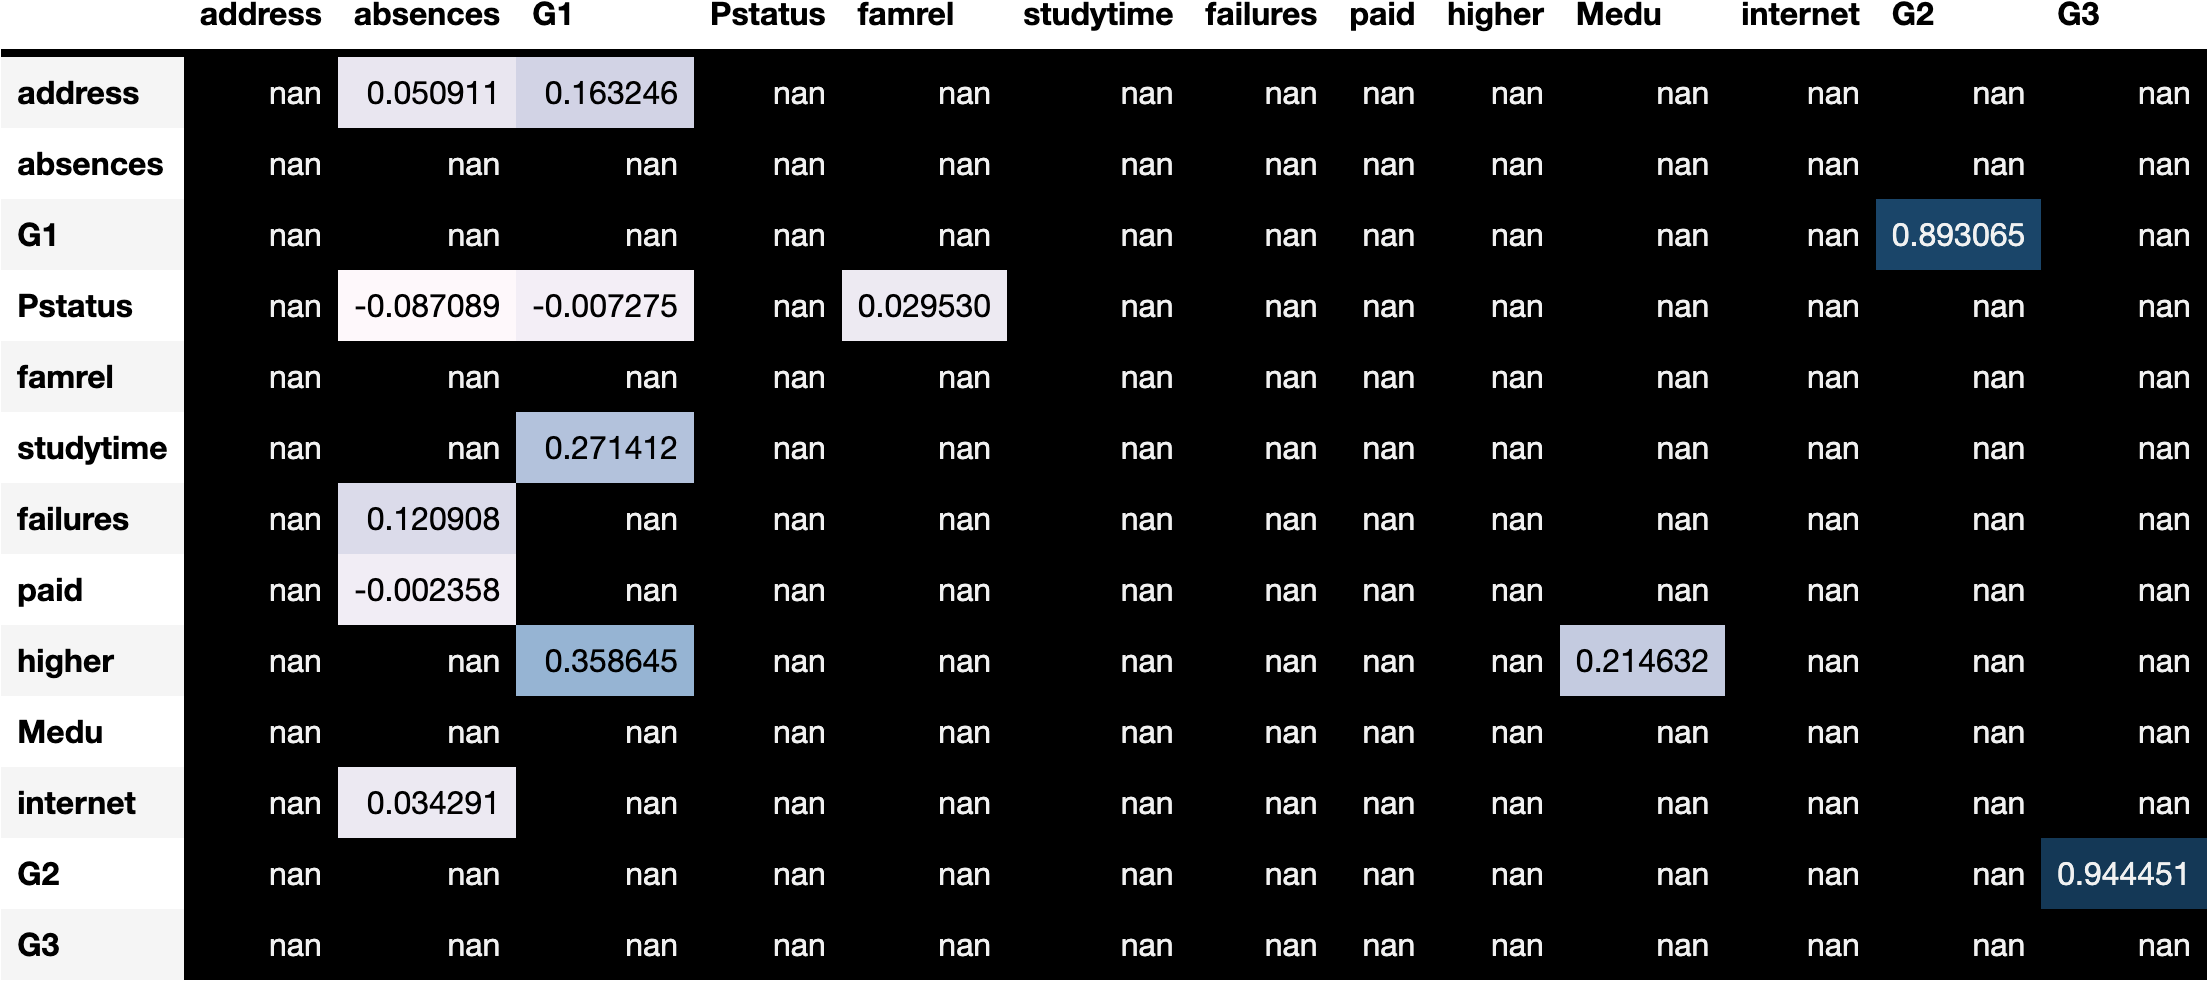

In [21]:
correl_df = utils.adjacency_correlations(struct_data, bn, 'spearman')    
utils.display_colored_df(correl_df)

In [22]:
correl_df.style.background_gradient(axis=None)

,address,absences,G1,Pstatus,famrel,studytime,failures,paid,higher,Medu,internet,G2,G3
address,nan,0.050911,0.163246,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
absences,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
G1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.893065,nan
Pstatus,nan,-0.087089,-0.007275,nan,0.029530,nan,nan,nan,nan,nan,nan,nan,nan
famrel,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
studytime,nan,nan,0.271412,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
failures,nan,0.120908,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
paid,nan,-0.002358,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
higher,nan,nan,0.358645,nan,nan,nan,nan,nan,nan,0.214632,nan,nan,nan
Medu,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


As we can see here, `G2` and `G3` has a Spearman score of 0.94 and `G2` is the parent of `G3`.
Therefore, based on our strategy, we will place an LV between those two nodes.

In [23]:
import copy

edges_to_add = [('LV', 'G2'), ('LV', 'G3')]
edges_to_remove = [('G2', 'G3')]

bn_with_lv = copy.deepcopy(bn)
bn_with_lv.add_node(
    "LV",
    edges_to_add=edges_to_add,
    edges_to_remove=edges_to_remove,
)

In [24]:
viz = utils.plot_pretty_structure(bn_with_lv.structure, edges_to_highlight=edges_to_add)
viz.show("supporting_files/05_node_added.html")

#### Comparison with baseline performance

Finally, we can compare the performance of the model with the addition of the LV and that of the base/original model.

In [25]:
discretised_data['LV'] = None
lv_states = [0, 1, 2, 3, 4]

proposed_auc = utils.get_avg_auc_lvs(discretised_data, bn_with_lv, lv_states)
print(f"AUC from adding LV between 'G2' and 'G3': {proposed_auc}")

Processing fold 0 using 7 cores takes 25.064236164093018 seconds
Processing fold 1 using 7 cores takes 21.276576042175293 seconds
Processing fold 2 using 7 cores takes 18.694112062454224 seconds
Processing fold 3 using 7 cores takes 18.850059032440186 seconds
Processing fold 4 using 7 cores takes 18.873937845230103 seconds
AUC from adding LV between 'G2' and 'G3': 0.8519607547762835


With an AUC score of 0.857, our new model has outperformed the baseline model,
which indicates that the LV is a worthy addition to the graph.

## Appendix

### How to choose where to add an LV?

One should always add LV edges based on the known true causality relationship. 

However, certain configurations allow EM to more likely converge to the correct CPD parameters of the LV.
Other configurations make it more difficult for EM to learn the correct parameters and may create misleading results.

Understanding these configurations is therefore crucial to adding latent variables to a BN.

### An interesting property of EM for Bayesian networks

Applying EM for Bayesian Networks in our current setting (i.e. no missing data except for the LV itself) has the following property:

> **The only parameters that need to be learned through EM are the  [CPDs](./05_latent_variable_tutorial.html#Definitions) of the LV itself and its children.** The other parameters CPDs can be learned directly using MLE.

This property comes directly from the conditional independence on which the BN is based.

From this property, we can limit ourselves to understanding the behaviour of EM given the LV's [Markov blanket](./05_latent_variable_tutorial.html#Definitions).
We detail the different possible situations we can face in the next section.

### What structures allow EM to correctly recover parameters?

In order for EM to learn meaningful parameters, **there has to be some correlation between variables that is not explained by the edges among observed variables**.

A few cases in which EM works well:

1. In the naive Bayes structure below, EM can work well because a possible correlation between the observed variables can only be explained by a causality of the LV ($Z$)

![naive-bayes](supporting_files/naive_bayes.jpg)

2. In the following structure, $Z$ explains the correlations among the nodes on the bottom, and also the correlation between nodes on top and the ones on the bottom.
   It is likely that we are able to recover the correct parameters in this situation.

![parent-latent-child-2](supporting_files/parent_latent_child.jpg)

Other cases where EM is not likely to provide meaningful parameters:

1. When the LV has no children, it would be quite difficult to infer its true parameters. EM will still converge but not necessarily to a meaningful result.

![childless-latent](supporting_files/childless_latent.jpg)

2. Below we have a structure whereby the children are fully connected. In this case, even if, in reality, the unobserved variable affects all children, all the correlations could be derived from the existing edges.
   The edge $e \rightarrow f$ explains the correlation between $a$ and $b$ for example. Therefore, EM would likely not retrieve the correct parameters for $Z$.

![connected](supporting_files/connected.jpg)


### Definitions

[1] A CPD of a node $X$ is a table specifying the probability $P(X|Parents(X))$. In a discrete Bayesian Network, these are provided as tables. The parameters of a BN are the set of the entries in every node.

[2] A Markov Blanket of a node is defined as the set of its parents, its children and its parent's children


## References

[1] J. Binder, D. Koller, S. Russell, and K. Kanazawa. "Adaptive Probabilistic Networks with Hidden Variables", Machine Learning, 29(2-3):213-244, 1997.

[2] A. P. Dempster, N. M. Laird, and D. B. Rubin. "Maximum Likelihood from Incomplete Data via the EM Algorithm", Journal of the Royal Statistical Society. Series B (Methodological), 39(1):1-38, 1977.